# Analyse de sentiments sur une base de données d'avis Amazon 

## Adnane Boukhari, Lohan Le Berrigaud

### Projet de NLP dans le cadre du cours de machine learning du master MFD (ENPC/UPEM)

## Introduction

L'objectif de ce projet est de proposer un notebook illustrant différentes méthodes de machine learning pour réaliser de l'analyse de sentiments sur des données textuelles. La tâche à réaliser est la classification de chacune des reviews comme positive ou négative. Nous travaillons dans le cadre de l'apprentissage supervisé car nos données sont labelisées. Nous présentons dans ce notebook toutes les étapes pour arriver à la classification.  
Le langage de programmation utilisé est Python. 

## Présentation du dataset 
Nous disposons d'une base de données contenant 12805 avis sur des softwares achetés via la plateforme Amazon. Ce jeu de données provient du site http://jmcauley.ucsd.edu/data/amazon/. Le fichier de données est sous le format *json*. La librairie *pandas* de Python permet de manipuler aisément ces données sous format de Dataframe.


Regardons à quoi ressemble notre base de données.

In [278]:
import pandas as pd

In [279]:
df=pd.read_json(r'C:\Users\Lohan\Desktop\Software_5.json',lines=True) #lines=True pour que ça marche (lecture ligne par ligne)


In [280]:
df.head()


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


In [281]:
print(df.shape) #taille du dataset


(12805, 12)


Pour notre projet, seules les colonnes "overall" et "reviewText" nous intéressent. 

In [282]:
df=pd.concat([df["overall"],df["reviewText"]],axis=1) #pour garder uniquement les reviews et notes

In [283]:
df.tail()

,overall,reviewText
12800,4,When I ordered this it was listed as Photo Edi...
12801,3,This software has SO much going on. Theres a ...
12802,4,I have used both more complex and less complex...
12803,3,Pinnacle Studio 20 Ultimate is a perfectly ser...
12804,4,A program that is fairly easy to use and provi...


In [284]:
print(df['reviewText'].iloc[5]) #jetons un oeil à une review ainsi qu'à la note attribuée
print("")
print("")
print("Note: ",df['overall'].iloc[5]) 

The video is well-paced and delivered in an understandable manner.  It allows you to work with the software while watching and following the directions of instructor Candyce Mairs.  To me, the book is more of a reference guide, something I would access with a specific need or question, because overall I learn better by seeing and doing than by reading.  The video starts with the basics and builds logically.  This is everything you want in a teaching video/book!


Note:  5


Attribuons maintenant les labels de la manière suivante : 

Overall > 3 : avis positif (label=1)
Overall < 3 : avis négatif (label=0)

Nous ne conservons pas les avis qui ont la note de 3 car nous jugeons ces avis difficiles à labelliser.


In [285]:
df=df.drop(df[df.overall==3].index) # on enlève les avis qui ont pour note 3
df=df.dropna() # on enlève les avis qui ne disposent pas de commentaire 
df.index=[i for i in range (df.shape[0])] #on réindexe correctement la dataframe après la suppression des lignes de note 3

In [286]:
df.shape # il nous reste 11206 avis

(11206, 2)

In [287]:
import numpy as np
df['label']=np.where(df.overall>3,1,0) # assignation des labels 


Regardons la répartition des labels dans notre jeu de données.

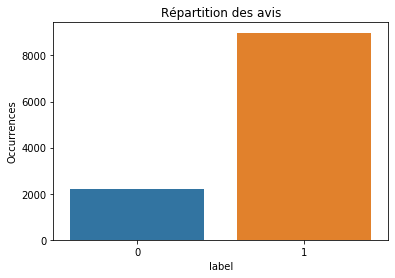

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x='label', data=df)
ax.set_title('Répartition des avis')
ax.set_ylabel('Occurrences')
plt.show()

Nous observons une proportion très importante d'avis positif (environ 80%). Nous allons entraîner nos algorithmes d'apprentissage sur ce jeu de données déséquilibrées. Dans le cas où nous n'obtiendront pas de résultats corrects, nous pourront aborder différentes techniques de rééchantillonage pour gérer le caractère déséquilibré de nos données. 

## Nettoyage et préparation des données

Parmi les données textuelles dont nous disposons, plusieurs données ne sont pas utiles pour l'analyse car non porteuses d'information. De plus, le format actuel des données n'est pas adapté à son étude. Nous allons donc procéder à plusieurs étapes pour préparer nos données pour la suite de l'analyse. 

Il est important de garder en tête qu'il n'existe pas de recette toute faite pour cette étape, et que chaque tache dépend de ce que l'on souhaite entreprendre et est propre à nos données.

### Tokenization

La tokenisation consiste à convertir le texte en un ensmble de mots ("tokens") qui sera ensuite plus facile à convertir en nombre. En effet, les algorithmes de machine learning requièrent des nombres en input pour pouvoir fonctionner.

Plus concrètement, cette étape consiste à supprimer tout ce qui n'est pas de type mot, c'est-à-dire la ponctuation, les nombres, les URLs et symboles.  Dans certains cas, comme ceux des Tweets par exemple, il peut être intéressant de conserver les smileys car ils sont sources d'information. 
La principale problématique de cette partie est de déterminer ce qui caractérise la séparation entre les mots. La plupart du temps, la séparation est caractérisée un espace. Nous remarquons que cela peut poser problème pour les mots composés ou noms propres comme par exemple "Los Angeles". Cette méthode reste tout de même très efficace, nous allons donc opter pour celle-ci.
Nous utilisons la librairie *re* (gestion des *regular expressions*) ainsi que la fonction *split* de Python pour réaliser cette tache.

### Stop words Removal

Cette étape correspond à la suppression des mots de type pronoms, préposition, conjonctions,...etc. Ces derniers n'apportent pas d'informations sur le texte. Pour réaliser cette tache nous avons le choix entre créer notre dictionnaire de mots à supprimer ou bien utiliser un dictionnaire déjà implémenté dans une librairie. Nous optons pour la deuxième option et utilisons le corpus de mots *stopwords* de la librairie *NLTK*.

### Stemming

Parmi les tokens dont nous disposons, certains ont la même racine lexicale. Par exemple un verbe et ses conjugaisons ont même racine. Toujours le but de garder le maximum d'information tout en minimisant la complexité de nos données, nous conservons la racine commune. Nous utilisons *PortStemmer* de *NLTK* pour cela.

### Transcription des trois étapes en code

In [289]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [290]:
corpus = []

for i in range(df['reviewText'].size):
    review = re.sub('[^a-zA-Z]', ' ', df['reviewText'][i]) #remplace tous les caractères de type autre que lettre par des espaces
    review = review.lower() #met le texte en minuscule (par soucis de normalisation) peut conduire à une perte de sens ex: Apple(marque) et apple(pomme) 
    review = review.split() #sépare les mots (espace considérer comme séparateur)
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))] #supprime les stopwords et conserve uniquement la racine des mots
    review = ' '.join(review)
    corpus.append(review)




In [294]:
print(corpus[5])

video well pace deliv understand manner allow work softwar watch follow direct instructor candyc mair book refer guid someth would access specif need question overal learn better see read video start basic build logic everyth want teach video book


## Représentation des mots

Intéressons nous maintenant à la conversion des mots en données utilisables par les algorithmes de machine learning. Pour cela nous abordons deux approches différentes. Nous verrons qu'en fonction de l'approche choisie nous allons privilégier un préparation des données textuelles plus ou moins sophistiquée. 

Il existe plusieurs grandes méthodes de représentation des mots en données numériques. 
La première appelée *Bag-of-words* est la plus accessible. Il s'agit de recenser dans un "sac de mots" chacun des mots distincts appartenant à nos données textuelles, puis de représenter le texte par un vecteur dans lequel chaque terme "i" correspond à la fréquence d'appartition du i-ème mot du "sac de mots". Cette méthode présente le désavantage de pas prendre en compte le contexte entourant chaque mot.

Considérons un exemple simple.

In [266]:
phrase1="I love that book."
phase2="I hate this book, I would rather have that one. "

sac_de_mot={'I','love','that','book','hate','this','would','rather','have','one'} # ensemble des mots 

phrase1_vec=[1,1,1,1,0,0,0,0,0,0] #représentation vectoriel de la phrase selon bag-of-words
phrase2_vec=[2,0,1,1,1,1,1,1,1,1]

Nous allons nous intéresser aux deux autres méthodes plus utilisées en pratique car plus complètes.

### Méthode TF-IDF (Term Frequency-Inverse Document Frequency)



Cette méthode est proche de *Bag-of-words* mais elle attribue un poids à chaque mot. Ce poids correspond à l'importance qu'a un mot dans un jeu de données textuelles. Ce poids, compris entre 0 et 1, est d'autant plus grand que le mot apparaît souvent dans un avis et peu fréquemment dans l'ensemble des avis. Mathématiquement cela se transcrit en deux termes :


Le premier terme est le Term Frequency (TF) et correspond à la fréquence d'apparition d'un mot (par exemple "test") dans l'avis i

TF(test,i)=$\frac{N_i}{Card(avis_i)}$ avec $N_i$ le nombre d'apparition du mot dans l'avis i et $Card(avis_i)$ le nombre de mots de l'avis i.

Le deuxième terme est le Inverse Document Frequency (IDF) et caractérise l'importance du mot dans l'ensemble des avis

IDF(test)=$\frac{log(Card(data))}{N+1}$ avec $Card(data)$ le nombre d'avis total et $N$ le nombre d'avis dans lequel apparaît le mot.

Enfin le TF-IDF d'un mot dans l'avis i s'exprime comme

TF-IDF(test,i)=TF(test,i)*IDF(test)

Pour réaliser cette transformation nous utilisons la bibliothèque *scikit-learn*.

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer() #initialisation de la classe avec les paramètres par défaut

corpus_vectoriz=vectorizer.fit_transform(corpus) #on applique la méthode fit_transform de la classe TfidfVectorizer


In [343]:
print(corpus[5])
print(corpus_vectoriz[5])

for i in range(len(corpus_vectoriz[5].toarray()[0])):
    if (corpus_vectoriz[5].toarray()[0][i] !=0):
        print(corpus_vectoriz[5].toarray()[0][i])
        print(i)

video well pace deliv understand manner allow work softwar watch follow direct instructor candyc mair book refer guid someth would access specif need question overal learn better see read video start basic build logic everyth want teach video book
  (0, 4221)	0.10840808816179265
  (0, 7455)	0.20232409013471528
  (0, 1198)	0.09588504379606952
  (0, 77)	0.12257357330018404
  (0, 14851)	0.08190156698313139
  (0, 5512)	0.15962538002669419
  (0, 7653)	0.30351316759642305
  (0, 1766)	0.30351316759642305
  (0, 3308)	0.14937563370175874
  (0, 4777)	0.13573406081549974
  (0, 7709)	0.20842361992536343
  (0, 3093)	0.18413107676016474
  (0, 9181)	0.19632594324621963
  (0, 10335)	0.1391112516732023
  (0, 12167)	0.14877381096128342
  (0, 364)	0.11210500165778899
  (0, 13758)	0.13461651413022857
  (0, 6494)	0.24844147605865158
  (0, 12025)	0.06658747064065108
  (0, 11448)	0.10351621700944068
  (0, 7227)	0.10505862724235962
  (0, 14812)	0.06493760666262634
  (0, 14469)	0.15125011869917274
  (0, 10495)

### Word embedding: méthode Word2Vec

Nous allons maintenant aborder une méthode de représentation plus complète mais aussi sophistiquée.
Le word embedding consiste à représenter chaque mot comme un vecteur de nombres réels. Chacune des composantes représente une dimension dans un espace propre à chaque texte. L'idée de cette méthode est de prendre en compte l'environnement dans lequel se trouve chaque mot. Des mots ayant un contexte similaire sont susceptibles d'avoir un sens proche et ainsi seront représentés proches dans l'espace vectoriel propre au texte.

*Word2Vec* est une méthode de word embedding. Elle repose sur l'apprentissage d'un réseau de neurone simple avec une couche cachée. 

Deux architectures sont possibles. La première appelée CBOW (Continuous Bag of Words), essaye de prédire le mot à représenter à partir de son contexte. La deuxième appelée Skipgram, réalise la tâche inverse, elle essaye de prédire le contexte à partir du mot à représenter.


Le fait que *Word2Vec* réalise un apprentissage à partir du contexte implique que seul un nettoyage minimal des données est nécessaire (ponctuation,nombres,majuscule). Nous allons voir une méthode simple de nettoyage des données présente dans la librairie gensim. Il est important de noter que la méthode Word2Vec de gensim requiert que les données textuelles en input soit sous forme de liste de liste. Un choix doit se faire à ce stade. Soit nous entraînons Word2Vec à partir des phrases du corpus sans distinguer les avis. Le contexte de chaque mot sera celui de la phrase uniquement. Soit nous entraînons le modèle à partir des avis. Le contexte de chaque mot sera alors celui de l'avis. Dans tous les cas nous pouvons jouer sur le paramètre "window" pour définir le nombre de mot à prendre en compte pour le contexte. Nous optons pour la deuxième méthode avec le paramètre window laissé par défaut à 5. Chaque avis est représenté comme une liste de tokens.

*Word2Vec* prend beaucoup de temps à s'exécuter en grande dimension. Il est possible de paralléliser cette méthode pour aller jusqu'à 70 fois plus vite. Voici un lien qui explique comment procéder (https://rare-technologies.com/parallelizing-word2vec-in-python/).

In [299]:
import gensim
from gensim.models import word2vec
from gensim.utils import simple_preprocess

corpus_w2v=[]

for i in range (df['reviewText'].size):
    review_w2v=gensim.utils.simple_preprocess(df['reviewText'][i], deacc=False, min_len=2, max_len=5000) #tokenize et met en minuscule les reviews, max_len=5000 pour ne pas tronquer d'avis
    corpus_w2v.append(review_w2v)

In [300]:
print(len(corpus_w2v))

11206


In [301]:
print(corpus_w2v[5])

['the', 'video', 'is', 'well', 'paced', 'and', 'delivered', 'in', 'an', 'understandable', 'manner', 'it', 'allows', 'you', 'to', 'work', 'with', 'the', 'software', 'while', 'watching', 'and', 'following', 'the', 'directions', 'of', 'instructor', 'candyce', 'mairs', 'to', 'me', 'the', 'book', 'is', 'more', 'of', 'reference', 'guide', 'something', 'would', 'access', 'with', 'specific', 'need', 'or', 'question', 'because', 'overall', 'learn', 'better', 'by', 'seeing', 'and', 'doing', 'than', 'by', 'reading', 'the', 'video', 'starts', 'with', 'the', 'basics', 'and', 'builds', 'logically', 'this', 'is', 'everything', 'you', 'want', 'in', 'teaching', 'video', 'book']


In [310]:
vectorizer_embedding=word2vec.Word2Vec(corpus_w2v) # par défaut le model CBOW est utilisé dans gensim. Peut se changer en mettant sg=1
vocab=vectorizer_embedding.wv.vocab
vectorizer_embedding.save('modelw.bin')

In [362]:
print("nb de mots du corpus= ",len(list(vocab)))

nb de mots du corpus=  9676


In [314]:
#regardons la proximité des mots selon la norme euclidienne dans l'espace des mots du corpus
#il existe plusieurs autres métriques dans gensim et notament la methode "distance" de wv qui donne la "cosine distance" (plus véridique que l'euclidienne)
vectorizer_embedding.wv.most_similar(positive=['good', 'best'], negative=['worst'], topn=10)

[('great', 0.7066988348960876),
 ('decent', 0.5876394510269165),
 ('nice', 0.554094672203064),
 ('basic', 0.5281928777694702),
 ('useful', 0.5007157325744629),
 ('cheap', 0.49282628297805786),
 ('cool', 0.482278436422348),
 ('well', 0.4745471179485321),
 ('reasonable', 0.4654301702976227),
 ('necessary', 0.46262097358703613)]

In [325]:
print(vectorizer_embedding.wv['good']) #représentation du mot "good" dans l'espace à 100 dimensions généré par word2vec et propre au corpus

[-1.1215004  -0.5836157  -0.34325358 -2.0437238  -0.83649606  0.16805132
  2.1154962   2.0640593   2.198262    0.566252   -0.8285332   0.836665
 -0.20191745 -0.87328845  0.38476947  0.11135514 -0.86302406  0.7895437
 -0.45190275  0.41031286 -1.1264879   2.1046586   0.21066968 -1.6913953
 -2.0326855  -0.47932926  0.59363747 -0.33971703 -1.2064344  -0.14310731
 -2.022831   -3.0286088  -1.50022    -0.70105124  1.289155   -0.7052383
 -0.01610097  0.7686101  -1.9510108  -2.0948305   1.1000409   1.3181152
 -0.8038943  -0.8557793  -0.09555775 -0.5459339  -0.8665857   0.40919924
 -0.94513613  0.9786056   0.3345448  -0.35026678 -0.9570973  -0.04835731
  1.0301759  -0.34073082  0.17374237 -0.33066544 -1.8048232  -2.4831595
 -0.7472632   1.1685461   2.1337838   0.12972967  1.2806505  -1.6287391
 -0.52848953  0.16330434  0.65368974 -1.267219   -0.78675294 -1.0490166
  1.7124052   0.10839154  2.2236524  -1.3436732  -0.57015735 -1.2652531
 -0.84835994  0.17218265 -0.01426338  1.3413174  -1.2873511  

Maintenant que nous disposons d'une représentation vectorielle pour chaque mot, il faut construire une représentation vectoriel pour chaque avis. Pour ce faire, la manière la plus simple qui nous vient à l'esprit est de sommer l'ensemble des vecteurs qui composent un avis.

In [351]:
#fonction pour construire le vecteur d'un avis 
def buildVector(tokens, size):
    vector = np.zeros(size).reshape((1, size))
    
    for word in tokens:
        try:
            vector += vectorizer_embedding.wv[word].reshape((1, size)) 
        except KeyError: # gère le cas où le token n'appartient pas au corpus
        
            continue
    
    return vector.ravel()

In [352]:
corpus_vectoriz_w2v=[] #liste qui contiendrait l'ensemble des vecteurs des avis

for i in range (len(corpus_w2v)):
    corpus_vectoriz_w2v.append(buildVector(corpus_w2v[i],100)) #ici size=100 comme pour la taille du vecteur en sortie de word2vec

In [353]:
print(corpus_vectoriz_w2v[0]) #représentation vectoriel du premier avis avec word2vec

[ -28.39637792    5.77769959  -48.63233441  -12.98107414   23.37487753
  -45.16070701   32.93549209   56.48523351   80.53115965  -15.10519877
    3.84199311  -29.41442971   25.86772105   53.14412515  -64.20978323
   13.64747036    9.35275921   70.9543549   -10.10992061  -49.79386658
   18.92522091    8.67394608   -5.54939832   35.60283208  -58.92950943
    1.9717865    77.0957176    79.47593264  -96.76952004  -32.34364141
  -71.50929232  -27.2314714   -10.86142391   38.99015572   34.54045115
   14.70453024   -0.85636487   -2.34171202   -4.8932378   -87.06210049
   -3.80007606   -8.37375597   81.13700766  -46.22219139  -42.7949718
    7.23350191   -9.47012472  -49.8420586   -15.91031389    3.06918273
   60.81914913   35.21916598  -20.37384666  -14.58019453  120.33404471
   22.03469806    7.58711387    0.59050081 -112.58755038  -88.15979557
  -27.6457695    53.21899452   21.56950874  -91.63983161   51.9108395
  -19.36062173   34.41918491  -35.75927188   65.23301559 -102.41457721
   25.97

### Répartition des données en jeu d'apprentissage et jeu de test

Nous choisissons une répartition classique 80% pour l'apprentissage et 20% pour le test.

In [408]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(corpus_vectoriz.toarray(), df['label'], test_size=0.2, random_state=0)

x_train_w2v, x_test_w2v, y_train, y_test =train_test_split(corpus_vectoriz_w2v,df['label'], test_size=0.2, random_state=0)

In [265]:
print("taille de l'échantillon d'apprentissage = ",y_train.size)
print("nombre de labels positifs parmi l'échantillon d'apprentissage = ",sum(y_train)) 

taille de l'échantillon d'apprentissage =  8964
nombre de label positif parmi l'échantillon =  7177


## Méthodes de classification

Nous allons essayer différentes méthodes de classification sur notre jeu de données. Nous comparerons l'efficacité de trois algorithmes classiques de machine learning ainsi qu'une méthode de deep learning. La bibliothèque *scikit-learn* propose une implémentation des algortihmes classiques de classification et la bibliothèque *keras* permet d'implémenter aisément un réseau de neurones.

### Régression logistique

La régression logistique est une méthode de classification couramment employée car efficace et ayant une bonne interprétabilité.
Présentons le modèle dans le cadre de notre problématique.

Notons $X$ l'ensemble des variables prédictives du modèle. Dans notre cas il s'agit des avis qui ont été transformés sous forme de vecteurs de nombres. Notons $Y$ l'ensemble des variables à prédire. Ce sont les labels des avis (1 pour positif, 0 pour négatif). L'hypothèse de ce modèle est que:

$ln\left(\frac{\mathbb{P}(X|Y=1)}{\mathbb{P}(X|Y=0)}\right)=a_0+a_1X_1+...+a_nX_n$ où n est le nombre de variables prédictives

Cette hypothèse est vérifiée pour un grand nombre de distributions telles que la loi normale, la loi gamma, les lois discrètes, etc...

Le théorème de Bayes s'écrit:

$\frac{\mathbb{P}(Y=1|X)}{\mathbb{P}(Y=0|X)}$=$\frac{\mathbb{P}(Y=1)\mathbb{P}(X|Y=1)}{\mathbb{P}(Y=0)\mathbb{P}(X|Y=0)}$

Le modèle de régression est alors le suivant:

$ln\left(\frac{\mathbb{P}(Y=1|X)}{\mathbb{P}(Y=0|X)}\right)=b_0+b_1X_1+...+b_nX_n$ 

Notons $\mathbb{P}(Y=1|X)=P(X)$, nous pouvons alors exprimer $P(X)$ ainsi

$P(X)=\frac{exp (b_0+b_1X_1+...+b_nX_n)}{1+exp (b_0+b_1X_1+...+b_nX_n)}$



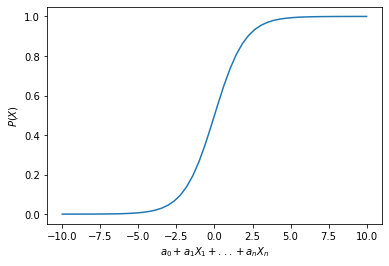

In [261]:
x=np.linspace(-10,10)
y=np.exp(x)/(1+np.exp(x))
plt.xlabel('$b_0+b_1X_1+...+b_nX_n$')
plt.ylabel('$P(X)$')
plt.plot(x,y)
plt.show()

La phase d'apprentissage consiste à calibrer les coefficients $b_0,...,b_n$ de la régression sur notre jeu de données test.
La détermination des coefficients peut se faire par la méthode du maximum de vraissemblance. Dans la pratique ce problème d'optimisation est résolu par la méthode de Newton-Raphson.

La phase de prédiction consiste à entrer notre jeu de données "test" en input, et pour $b_0+b_1X_1+...b_nX_n >0,5$, l'algorithme retourne le label 1 en sortie et 0 sinon.

In [263]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train) #apprentissage

C:\Users\Lohan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Remarquons que les réglages par défaut de *scikit-learn* ajoutent une pénalisation L2 à la régression.

In [264]:
print(logreg.score(x_test,y_test))# la méthode score renvoie le taux de prédiction correcte réalisée

0.8916146297948261

In [355]:
logreg.fit(x_train_w2v, y_train)
print(logreg.score(x_test_w2v,y_test))

C:\Users\Lohan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.852363960749331


### Random forest

Random forest est également un algorithme de classification généralement très performant qui repose sur les arbres de décision.

Un arbre de décision peut être caractérisé par deux attributs, à savoir: les branches et les noeuds. 
A chaque noeud, un critère discriminant sur les variables de notre dataset permet de séparer le jeu de données en deux branches. Le choix du critère discriminant à chaque noeud doit se faire de manière à minimiser un certain paramètre. En général le paramètre choisi pour la classification est l'indice de Gini. Cet indice traduit la ressemblance entre les données d'un groupe. Un indice de Gini de 0 signifie que les données sont identiques, tandis qu'un indice de 1 traduit une distinction totale entre les données (théoriquement impossible). Cette étape ensuite répétée sur les données de chaque branche. L'arbre se termine lorsque la réduction du paramètre n'est plus significative. 

Bien que très facilement interprétable, l'arbre de décision exhibe une variance importante. En effet cette méthode est très sensible aux données en input, et une légère modification des celles-ci peut conduire à un résultat très différent.


L'algorithme Random forest consiste en un ensemble particulier d'arbre de décisions. La classification en sortie de Random forest correspond à la classification la plus représentée parmi l'ensemble des arbres décisionnels. Random forest affiche une variance bien moindre que dans le cas d'un unique arbre de décision. Ce résultat repose sur deux éléments.


Le premier élément est la méthode de sélection des données qui vont être analysées par les arbres de décisions composant la forêt. La méthode employée est celle du bagging. Elle consiste à sélectionner des échantillons de manière aléatoire et avec remplacement (ce qui signifie qu'une donnée peut se retrouver dans plusieurs arbres). La méthode de bagging "classique" consisterait ensuite à sélectionner la prédiction la plus commune au sein de la forêt d'arbre décisionnels. La variance de cette méthode ne serait que légèrement inférieure à celle de chacun des arbres car ces derniers sont très corrélés.
En effet, imaginons qu'un critère discriminant soit dominant (c'est-à-dire qu'il est présent sur un nombre important d'arbres). Alors les classifications obtenus seront très proches.

Ce qui nous ammène au deuxième point qui fait la force de Random forest: la faible corrélation entre les arbres décisionnels.
Pour obtenir des arbres faiblement corrélés, à chaque noeud la séparation s'effectue à partir d'un sous-ensemble de critère discriminant choisi au hasard. On ne considère alors plus forcément le "meilleur" de tous les critères discriminants mais seulement le meilleur parmi le sous-ensemble.


Le fait de déterminer la classification comme la classification majoritaire au sein d'une forêt d'arbres décisionnels peu corrélés permet à Random Forest d'obtenir un pouvoir prédictif intéressant.


In [328]:
from sklearn.ensemble import RandomForestClassifier

cla_RF=RandomForestClassifier(n_estimators=100, random_state=0)  # nous considérons 100 arbres décisionnels dans la forêt

cla_RF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [329]:
cla_RF.score(x_test,y_test)

0.8760035682426405

In [356]:
cla_RF.fit(x_train_w2v,y_train)
print(cla_RF.score(x_test_w2v,y_test))

0.8782337198929527


### K-NN

La méthode des "*K* plus proches voisins" *K*-NN (nearest neighbours) est un algorithme de machine learning non paramétrique pouvant être utilisé pour la classification. Il fait partie des algorithmes les plus connus car il est aisément compréhensible.

Chaque prédiction est réalisée en regardant le label majoritaire des *k* variables les plus proches de la variable à labelliser (au sens d'une certaine distance dont l'espace des variables est muni, en général l'on choisit la distance euclidienne). 

Pour déterminer le k adéquat, nous réalisons une boucle for pour k allant de 2 à 10 et nous sélectionnons le k qui obtient le score le plus important. 

Un des points faibles de cet algorithme est qu'il est sensible à l'asymétrie des données d'apprentissage. Dans notre cas, les données sont déséquilibrées (près de 4 fois plus d'avis positifs que de négatifs). Si le nombre de voisins précisés en input est significatif par rapport au nombre d'avis négatifs, les résultats peuvent être faussés. Une solution pour remédier à cela serait d'attribuer un poids à chaque voisin qui serait inversement proportionnel à la distance à l'avis à labelliser. 

In [331]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(3)
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [332]:
knn.score(x_test,y_test)

0.7805530776092774

L'algorithme K-NN a mis énormément de temps à tourner, nous ne pouvons donc déterminer de k optimal avec nos données sans doute trop importante. Nous nous arrêtons avec cette algorithme.

### Comparaison des résultats avec les trois algorithmes

Au delà des scores donnés ci-dessus, analysons la courbe ROC des algorithmes Random Forest et régression logistique. 
Cette courbe présente des informations plus précises sur la qualité de prédiction de chacun des modèles de classification. Cette courbe est d'autant plus pertinente que les données d'apprentissage sont asymétriques.

En abscisse est représenté le "Taux de faux positifs" (TFP) qui s'exprime comme la part d'avis négatifs qui ont été labellisés par les modèles. En ordonnée, le "Taux de vrai positifs "(TVP) correspond à la part d'avis positifs correctement labellisés.

Remarquons que la labellisation s'effectue selon le critère d'acceptation suivant si $\mathbb{P}(Y=1|X)>0,5$ alors $Y$ a pour label 1. Pour construire la courbe ROC, nous faisons varier le seuil d'acceptation de 0 à 1 et nous calculons les valeurs de TFP et TVP pour les differents seuils.

L'aire sous la courbe notée AUC représente la qualité d'apprentissage. Une AUC de $0,5$ signifie que le modèle n'a pas de pouvoir prédictif et fait aussi bien que le hasard. Une AUC de $1$ signifie quand à elle que le modèle prédit parfaitement les labels.

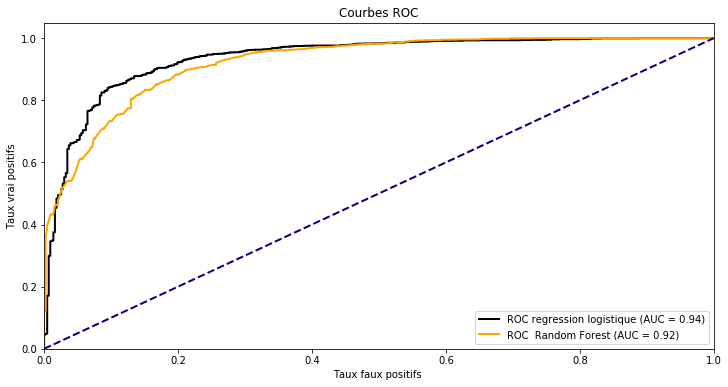

In [335]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fprRF, tprRF, thresholdsRF = metrics.roc_curve(y_test, cla_RF.predict_proba(x_test)[:,1])
fprl, tprl, thresholdsl = metrics.roc_curve(y_test, logreg.predict_proba(x_test)[:,1])

plt.figure(figsize=(12,6))
lw = 2
plt.plot(fprl, tprl, color='black',
         lw=lw, label='ROC regression logistique (AUC = %0.2f)' % auc(fprl, tprl))
plt.plot(fprRF, tprRF, color='orange',
         lw=lw, label='ROC  Random Forest (AUC = %0.2f)' % auc(fprRF, tprRF))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs ')
plt.ylabel('Taux vrai positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

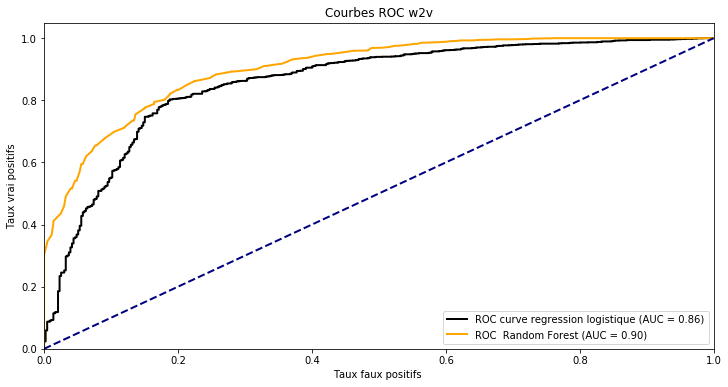

In [358]:

fprRF, tprRF, thresholdsRF = metrics.roc_curve(y_test, cla_RF.predict_proba(x_test_w2v)[:,1])
fprl, tprl, thresholdsl = metrics.roc_curve(y_test, logreg.predict_proba(x_test_w2v)[:,1])

plt.figure(figsize=(12,6))
lw = 2
plt.plot(fprl, tprl, color='black',
         lw=lw, label='ROC curve regression logistique (AUC = %0.2f)' % auc(fprl, tprl))
plt.plot(fprRF, tprRF, color='orange',
         lw=lw, label='ROC  Random Forest (AUC = %0.2f)' % auc(fprRF, tprRF))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs ')
plt.ylabel('Taux vrai positifs')
plt.title('Courbes ROC w2v')
plt.legend(loc="lower right")
plt.show()

Les algorithmes sont tous deux satisfaisants. Nous ne pouvons en privilégier un en se fiant uniquement à ces courbes, il faudrait étudier chaque prédiction en jouant sur tous les paramètres de manière à trouver les paramètres optimaux.

Nous remarquons que le score obtenu est légèrement moins bon avec *Word2Vec*. La paramétrisation de cette méthode étant complexe, nous suggérons que ce moins bon score s'explique ainsi. Ajoutons à cela que nous avons créer les vecteur de chaque avis en effectuant une somme des vecteurs des mots le composant. Peut-être serait-il plus judicieux de réaliser une moyenne pondérée en attribuant plus de poids aux mots porteurs d'informations (mots avec un TF IDF important). Cette piste sera à approfondir lors d'une prochaine étude.

Un facteur non mentionné auparavant qui est également à prendre en compte est la vitesse d'exécution des algorithmes. La régression logistique est bien plus rapide que les deux autres méthodes. K-NN est la plus longue et n'est pas à privilégier avec des jeux de données importants.

### Deep learning: réseaux LSTM

Etudions un dernier type d'algorithme. Celui ci est différent des précédents puisqu'il s'agit d'un algorithme de deep learning.
Nous avons brièvement évoqué les réseaux de neurones avec Word2Vec. Les réseaux de neurones représentent un domaine vaste et complexe du machine learning. Nous les présentons et exposons succintement la particularité du réseau LSTM (Long Short Term Memory). 

Un réseau de neurones est une architecture composée de plusieurs couches de neurones utilisée pour réaliser des prédictions, de la classification, etc... 

Nous présentons ci-dessous le type de réseau de neurones traditionnel.
Le première couche prend en compte les inputs du modèle. Nous retrouvons ensuite un certain nombres de couches intermédiaires appelés couches cachées ("hidden layers" en anglais). Enfin la dernière couche contient en sortie les prédictions. Chaque neurone est relié à ceux des couches adjacentes. A chaque liaison est attribuée un poids et à chaque neurone est associé un biais. La liaison arrive de la couche amont puis repart de la couche aval (architecture "forward"). Un score est attribuée en sortie en fonction de la prédicition réalisée. L'apprentissage consiste à trouver les poids et biais qui minimisent l'erreur en sortie. Pour ce faire, ces paramètres sont modifiés par descente de gradient en partant de la dernière couche et en remontant jusqu'à la première couche. En anglais cette méthode d'apprentissage est appelée "backpropagation". La description est simplificatrice (nous omettons la notion d'activation, de sigmoïd et nous n'avons pas donnés de détails sur la "backpropagation") mais elle permet d'avoir une idée simple du fonctionnement d'un réseau de neurones.

Les réseaux de neurones traditionnels tels que décrits ci-dessus présentent un problème important. Du fait de leur structure  ils ne peuvent garder en mémoire les informations déjà reçues. Il n'y pas persistance de l'information. Cela peut être problématique lorsque nous souhaitons par exemple prédire le prochain mot d'un texte.
Un type particulier de réseaux de neurones appelés RNN (Recurral Neural Network) remédie à ce problème. Un tel type de réseau possède des boucles sur les neurones permettant de garder l'information en mémoire.
Les RNN classiques ont cependant des problèmes avec la gestion de la mémoire à long terme. C'est là alors qu'interviennent les réseaux LSTM qui gèrent parfaitement ce genre de situation.

Pour revenir à notre problème de classification, la structure du LSTM semble particulèrement adapté.

Nous implémentons notre réseau LSTM à l'aide de la bibliothèque *keras*. Nous utiliserons le word embedding réalisé avec *Word2Vec* pour alimenter le réseau. 

In [366]:
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

In [404]:
reseau=Sequential()

reseau.add(layers.LSTM(32)) #on rentre en input le nombre de neurones souhaités

reseau.add(layers.Dropout(0.5)) #pour éviter l'overfitting, désactive certains neurones à chaque itération avec une probabilité de 0.5 ici

#la dernière couche est une sigmoid de manière à obtenir en sortie une valeur comprise entre 0 et 1 pour la classification
reseau.add(layers.Dense(1,activation='sigmoid')) 

# nous utilisons la 'binary_crossentropy' comme fonction de perte puisque nous réalisons de la classification 
#'sgd' correspond à un algorithme de descente de gradient stochastique
reseau.compile(loss='binary_crossentropy', 
                  optimizer='sgd',
                  metrics=['accuracy'])

#pour la conversion des données au bon format si l'on relance le notebook du début
x_train_w2v=np.array(x_train_w2v)
x_train_w2v=x_train_w2v.reshape(x_train_w2v.shape[0],1,x_train_w2v.shape[1])
y_train=y_train.tolist
y_train=np.array(y_train)

#batch correspond au nombre d'échantillon que le réseau doit avoir vu avant d'actualiser les paramètres du modèle
#epochs correspond au nombre de fois où le réseau a parcouru l'ensemble du jeu de données
reseau.fit(x_train_w2v, y_train,batch_size = 32, epochs = 5,verbose=2)
print(reseau.summary())

Epoch 1/5
 - 6s - loss: 0.5260 - accuracy: 0.7806
Epoch 2/5
 - 2s - loss: 0.4720 - accuracy: 0.8004
Epoch 3/5
 - 1s - loss: 0.4429 - accuracy: 0.8083
Epoch 4/5
 - 1s - loss: 0.4267 - accuracy: 0.8109
Epoch 5/5
 - 1s - loss: 0.4204 - accuracy: 0.8097
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 17,057
Trainable params: 17,057
Non-trainable params: 0
_________________________________________________________________
None


In [409]:
x_test_w2v=np.array(x_test_w2v)
x_test_w2v=x_test_w2v.reshape(x_test_w2v.shape[0],1,x_test_w2v.shape[1])

y_test=y_test.tolist()
y_test=np.array(y_test)
reseau.evaluate(x_test_w2v,y_test)

2242/2242 [==============================] - 1s 461us/step


[0.38422661929338986, 0.81534343957901]

Nous obtenons un score de classification de 0,815. Les résultats obtenus sont moins bons qu'avec les algorithmes précédents. D'après la littérature la combinaison *Word2Vec* + LSTM est celle qui produit les meilleurs résultats. Nous supposons que nos nos mauvais résultats proviennent en grande partie de la paramétrisation de *Word2Vec*. La paramétrisation du réseau de neurones n'est sans doute elle aussi pas optimale. Nous avons essayé de construire le réseau LSTM le plus facilement compréhensible. Peut-être qu'ajouter de la complexité permettrait d'obtenir de meilleurs résultats. Une méthode à essayer est de réimplémenter le réseau mais en utilisant les fonctions propres à *Keras* pour réaliser le texte preprocessing et de rajouter une couche d'embedding pour se passer de *Word2Vec*. 

### Conclusion

De manière générale les résultats obtenus avec les différentes méthodes sont satisfaisants. Cela justifie l'utilisation d'algorithmes de machine learning pour réaliser de l'analyse de sentiments. 

Une méthode relativement efficace et simple pour réaliser de la classification de texte est l'association de la régression logistique à TF-IDF.

L'importance de la paramétrisation est primordiale. Il est impératif de comprendre le principe de fonctionnement d'un modèle pour l'exploiter au mieux.

L'utilisation de réseau de neurones est la méthode la plus prometteuse d'après la littérature, cependant nous n'avons pas réussi à en tirer pleinement partie. 

Certain points ont été omis ou brièvement abordés dans ce notebook. La gestion de la négation, le déséquilibre des données d'apprentissage sont deux points importants. Il serait intéressant de les investiguer. 

Nous aurions pu également utiliser d'autres types de réseaux de neurones comme les CNN (convolutionnal neural network) pour réaliser la classification. 

### Sources

https://machinelearningmastery.com/

https://medium.com/

http://eric.univ-lyon2.fr/

https://towardsdatascience.com/

https://scikit-learn.org/stable/

https://keras.io/

https://github.com/

https://stackoverflow.com/